# Week 7: Model ensembling

### 0. Import the necessary libraries

In [ ]:
from torchvision.models import resnet50, vgg16
import torchvision.transforms as T
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

### 1. Pre preperation

#### 1.1 Loading fine-tuned VGG 16 and ResNet 50 models
This is done in the same way we did in weeks 5 and 6, when we're loading the pre-trained and fine-tuned models for inference. We create instances of the models with null weights, replace the final classifier layers to match the output dimensions, and load the weights from the saved models

In [ ]:
vgg16_model = vgg16(weights=None)
resnet50_model = resnet50(weights=None)

In [ ]:
vgg16_model.classifier[6] = torch.nn.Linear(4096, 4)
resnet50_model.fc = torch.nn.Linear(resnet50_model.fc.in_features, 4)

vgg16_model.load_state_dict(torch.load("/content/best_vgg_mri.pth", map_location="cpu", weights_only=True))
resnet50_model.load_state_dict(torch.load("/content/best_resnet_mri.pth", map_location="cpu", weights_only = True))

<All keys matched successfully>

#### 1.2 Data pre-processing
We are again using the same pre-processing steps for the test data as we did in weeks 5 and 6.

In [ ]:
preprocess = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

#### 1.3 Data loading
This is also done in the same way as we did in weeks 5 and 6.

In [ ]:
import kagglehub
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

100%|██████████| 71.5M/71.5M [00:00<00:00, 105MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


In [ ]:
test_dataset = ImageFolder(path + "/Combined Dataset/test", transform=preprocess)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Use a GPU if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use CUDA if you are not on Apple Silicon

Move the models to the GPU and set them to evaluation mode for inference.

In [ ]:
vgg16_model.to(device)
resnet50_model.to(device)

vgg16_model.eval()
resnet50_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2. Single Model Inference

#### 2.1 Collecting Softmax Outputs

To speed up inference, we'll only collect the softmax outputs from the loaded models, and later extract the predicted class from the outputs. The softmax outputs are obtained using a forward pass, as we've done in the previous weeks. The softmax outputs will also help us in the ensembling methods we'll explore in the next section.

In [ ]:
resnet_softmax = []
vgg_softmax = []
all_labels = []

In [ ]:
with torch.no_grad():
  # TODO: Implement single model inference for ResNet and VGG to store the respective softmax outputs
  for inputs, labels in test_dl:
    inputs = inputs.to(device)
    resnet50_logits = resnet50_model(inputs)
    vgg16_logits = vgg16_model(inputs)
    resnet_softmax.extend(torch.nn.functional.softmax(resnet50_logits, dim=1).cpu())
    vgg_softmax.extend(torch.nn.functional.softmax(vgg16_logits, dim=1).cpu())
    all_labels.extend(labels)

In [ ]:
resnet_softmax = np.array(resnet_softmax)
vgg_softmax = np.array(vgg_softmax)

Extracting predictions from softmax

In [ ]:
resnet_preds = resnet_softmax.argmax(axis=1)
vgg_preds = vgg_softmax.argmax(axis=1)

#### 2.2 Confusion Matrix and Performance Statistics
Here, we'll display a confusion matrix for both models, as we've done in weeks 5 and 6. We'll also compute the accuracy, precision, recall, and F1 score for each model, and compare them to each other.

In [ ]:
# Function to print the statistics of a model/ensemble output
def print_stats(stats):
    print(f"    Accuracy: {stats[0]:.2f}")
    print(f"    Precision: {stats[1]:.2f}")
    print(f"    Recall: {stats[2]:.2f}")
    print(f"    F1: {stats[3]:.2f}")

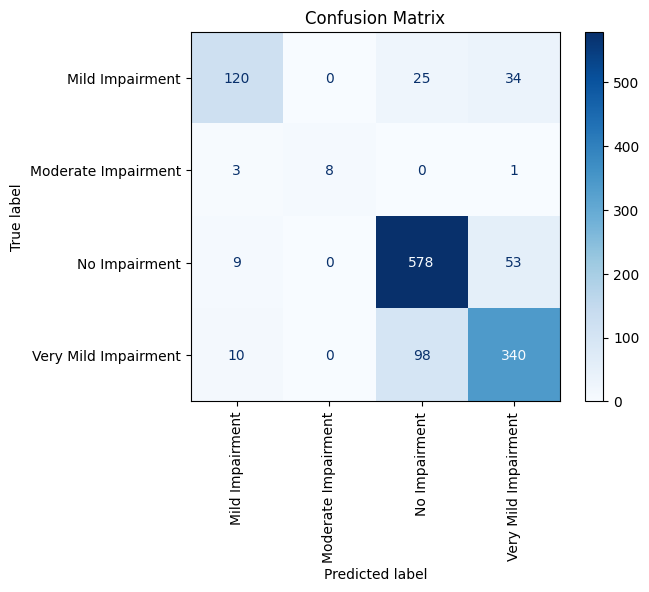

Classification Report ResNet50:
    Accuracy: 0.82
    Precision: 0.87
    Recall: 0.75
    F1: 0.80


In [ ]:
cm = confusion_matrix(all_labels, resnet_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Add accuracy, precision, recall, and f1
resnet_stats = [accuracy_score(all_labels, resnet_preds),
                precision_score(all_labels, resnet_preds, average='macro'),
                  recall_score(all_labels, resnet_preds, average='macro'),
                  f1_score(all_labels, resnet_preds, average='macro')]

print(f"Classification Report ResNet50:")
print_stats(resnet_stats)


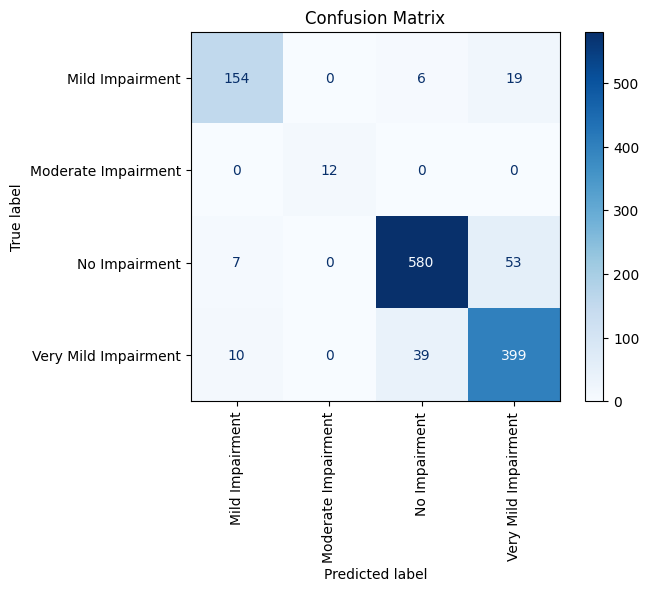

Classification Report VGG 16:
    Accuracy: 0.90
    Precision: 0.92
    Recall: 0.91
    F1: 0.92


In [ ]:
cm = confusion_matrix(all_labels, vgg_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Add accuracy, precision, recall, and f1
vgg_stats = [accuracy_score(all_labels, vgg_preds),
                precision_score(all_labels, vgg_preds, average='macro'),
                  recall_score(all_labels, vgg_preds, average='macro'),
                  f1_score(all_labels, vgg_preds, average='macro')]

print(f"Classification Report VGG 16:")
print_stats(vgg_stats)

### 3. Ensembling

#### 3.1 Plain average
In this method, we take the average (arithematic mean) of the softmax outputs of the two models. This provides a new softmax distribution, from which we can extract the predictions.

In [ ]:
plain_average_softmax = (resnet_softmax + vgg_softmax) / 2
plain_average_preds = plain_average_softmax.argmax(axis=1)

Storing plain average statistics and plotting the confusion matrix for the plain average outputs. We can see a noticable improvement in all 4 metrics with this ensemble strategy from the individual ResNet and VGG models.

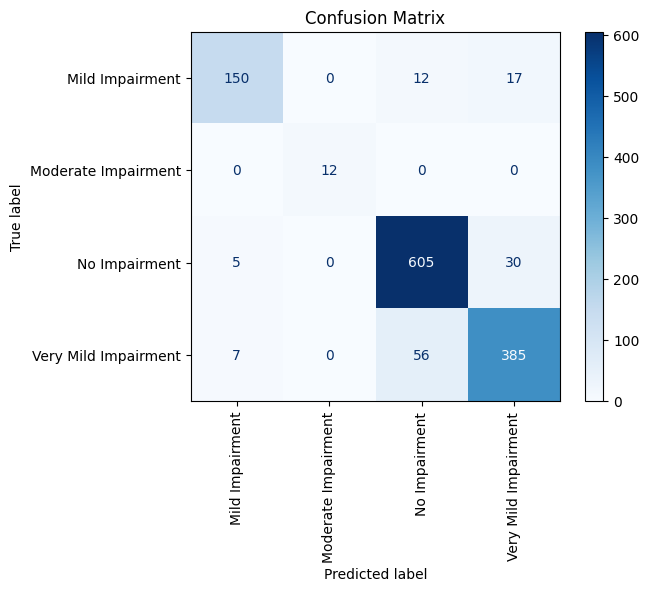

Classification Report Plain Average:
    Accuracy: 0.90
    Precision: 0.93
    Recall: 0.91
    F1: 0.92


In [ ]:
cm = confusion_matrix(all_labels, plain_average_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Add accuracy, precision, recall, and f1
plain_avg_stats = [
    accuracy_score(all_labels, plain_average_preds),
    precision_score(all_labels, plain_average_preds, average='macro'),
    recall_score(all_labels, plain_average_preds, average='macro'),
    f1_score(all_labels, plain_average_preds, average='macro')
]

print(f"Classification Report Plain Average:")
print_stats(plain_avg_stats)

#### 3.2 Weighted Average
In this method, we take the weighted average of the softmax outputs of the two models. This provides a new softmax distribution, from which we can extract the predictions. The weights are pre-determined for the models; I found 0.25 for ResNet and 0.75 for VGG worked reasonably the best, since VGG is overall a better performing model than ResNet. Feel free to change these weights based on your models' performances after fine-tuning.

In [ ]:
# TODO: Implement weighted average ensembling
weight_resnet = 0.4
weight_vgg = 0.6
weighted_softmax = weight_resnet * resnet_softmax + weight_vgg * vgg_softmax
weighted_preds = weighted_softmax.argmax(axis = 1)

Storing weighted average statistics and plotting the confusion matrix for the weighted average outputs. Again, all 4 metrics for the weighted average results are higher than the individual models. Additionally, the weighted average metrics are very marginally higher than the plain average metrics.

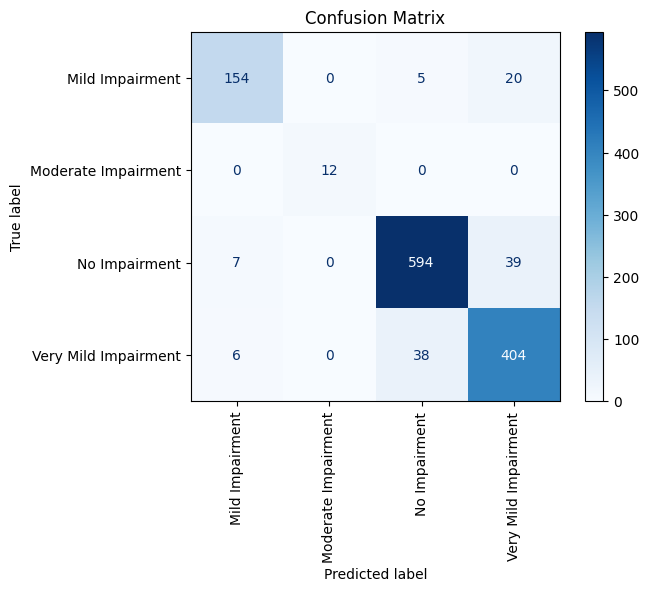

Classification Report Weighted Average:
    Accuracy: 0.91
    Precision: 0.93
    Recall: 0.92
    F1: 0.93


In [ ]:
cm = confusion_matrix(all_labels, weighted_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Add accuracy, precision, recall, and f1
weighted_avg_stats = [
    accuracy_score(all_labels, weighted_preds),
    precision_score(all_labels, weighted_preds, average='macro'),
    recall_score(all_labels, weighted_preds, average='macro'),
    f1_score(all_labels, weighted_preds, average='macro')
]

print(f"Classification Report Weighted Average:")
print_stats(weighted_avg_stats)

#### 3.3 Voting
The strategy here is to obtain the label predictions from each of the fine-tuned models and then decide the final label by consensus. With more than 3 models, we would pick the final label by the majority vote. However, with only 2 models, we pick the label if both the ResNet and VGG models agree on the same label, and default to the VGG prediction otherwise. This is because the VGG model in this case has a better performance than the ResNet model. Feel free to change this based on your models' performances.

In [ ]:
import random
voting_preds = []
for i in range(len(resnet_preds)):
  x = random.random()
  if x > 0.2:
    voting_preds.append(vgg_preds[i])
  else:
    voting_preds.append(resnet_preds[i])

Storing voting statistics and plotting a confusion matrix for voting predictions. Although the results are slightly better than the individual models (particularly ResNet in this case), it is not better than some of the other ensembling techniques, and even performs worse than the VGG 16 model in some metrics.

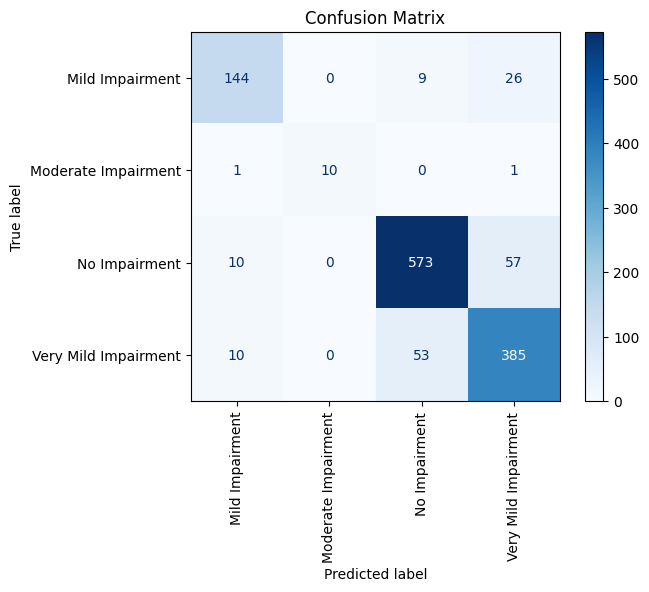

Classification Report Voting:
    Accuracy: 0.87
    Precision: 0.90
    Recall: 0.85
    F1: 0.87


In [ ]:
cm = confusion_matrix(all_labels, voting_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Add accuracy, precision, recall, and f1
voting_stats = [
    accuracy_score(all_labels, voting_preds),
    precision_score(all_labels, voting_preds, average='macro'),
    recall_score(all_labels, voting_preds, average='macro'),
    f1_score(all_labels, voting_preds, average='macro')
]

print(f"Classification Report Voting:")
print_stats(voting_stats)

### 4. Final Comparison of Ensembling Methods

Overall, ensembling did improve predictions than the individual models, particularly in the average-based techniques. However, from the previous weeks' gradcam implementations, we see that both the ResNet and VGG models picked up on similar features in predicting the same classes. Thus, the improvements obtained from ensembling, in this case, were not extremely
significant, with typically a 0.01-0.03 improvement.

*Note that the scale on the y axis is 0.6-1*

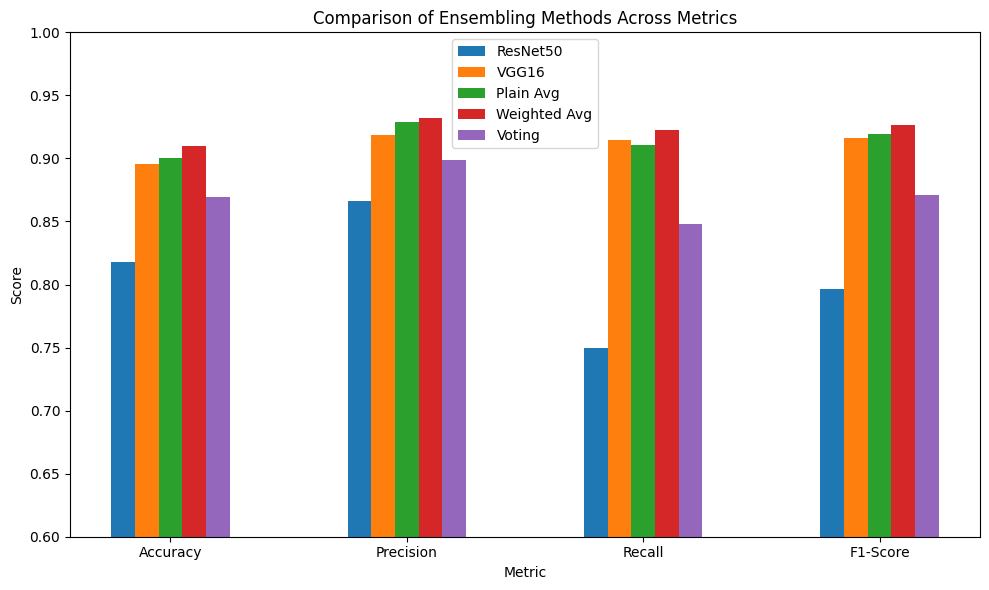

In [ ]:
methods = ['ResNet50','VGG16', 'Plain Avg', 'Weighted Avg', 'Voting']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Example metric scores for each method (rows = methods, columns = metrics)
scores = np.stack([resnet_stats, vgg_stats, plain_avg_stats, weighted_avg_stats, voting_stats])


# Parameters for plotting
bar_width = 0.1
x = np.arange(len(metrics))  # e.g., [0, 1, 2, 3]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, method in enumerate(methods):
    ax.bar(x + i * bar_width, scores[i], width=bar_width, label=method)

# Set labels and ticks
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Ensembling Methods Across Metrics')
ax.set_xticks(x + bar_width * (len(methods) - 1) / 2)
ax.set_xticklabels(metrics)
ax.set_ylim(0.6, 1.0)
ax.legend()

plt.tight_layout()
plt.show()